# Fuzzy AHP

In [ ]:
import numpy as np
import pandas as pd

def fuzzy_number(low, mid, high):
    return np.array([low, mid, high])

def fuzzy_reciprocal(a):
    return np.array([1 / a[2], 1 / a[1], 1 / a[0]])

def fuzzy_geometric_mean(fuzzy_numbers):
    n = len(fuzzy_numbers)
    product = np.prod(fuzzy_numbers, axis=0)
    return np.array([p ** (1 / n) for p in product])

def fuzzy_divide(a, b):
    return np.array([a[0] / b[2], a[1] / b[1], a[2] / b[0]])

# Random Consistency Index (RI)
RI = {
    1: 0.00, 2: 0.00, 3: 0.58, 4: 0.90, 5: 1.12,
    6: 1.24, 7: 1.32, 8: 1.41, 9: 1.45, 10: 1.49
}

# Response scale (fuzzy AHP)
# response_scale_ahp = {
#     "A mutlak lebih penting dibandingkan B": fuzzy_number(7, 9, 9),
#     "A sangat lebih penting dibandingkan B": fuzzy_number(5, 7, 9),
#     "A cukup lebih penting dibandingkan B": fuzzy_number(3, 5, 7),
#     "A sedikit lebih penting dibandingkan B": fuzzy_number(1, 3, 5),
#     "Sama pentingnya": fuzzy_number(1, 1, 1),
#     "B sedikit lebih penting dibandingkan A": fuzzy_reciprocal(fuzzy_number(1, 3, 5)),
#     "B cukup lebih penting dibandingkan A": fuzzy_reciprocal(fuzzy_number(3, 5, 7)),
#     "B sangat lebih penting dibandingkan A": fuzzy_reciprocal(fuzzy_number(5, 7, 9)),
#     "B mutlak lebih penting dibandingkan A": fuzzy_reciprocal(fuzzy_number(7, 9, 9))
# }

response_scale_ahp = {
    "A mutlak lebih penting dibandingkan B": fuzzy_number(9,9,9),
    "A sangat lebih penting dibandingkan B": fuzzy_number(6,7,8),
    "A cukup lebih penting dibandingkan B": fuzzy_number(4,5,6),
    "A sedikit lebih penting dibandingkan B": fuzzy_number(2,3,4),
    "Sama pentingnya": fuzzy_number(1, 1, 1),
    "B sedikit lebih penting dibandingkan A": fuzzy_reciprocal(fuzzy_number(2,3,4)),
    "B cukup lebih penting dibandingkan A": fuzzy_reciprocal(fuzzy_number(4,5,6)),
    "B sangat lebih penting dibandingkan A": fuzzy_reciprocal(fuzzy_number(6,7,8)),
    "B mutlak lebih penting dibandingkan A": fuzzy_reciprocal(fuzzy_number(9,9,9))
}

# Aggregate fuzzy matrix for various criteria comparisons
def aggregate_fuzzy_matrix(df, criteria, comparison_pairs, scale):
    n = len(criteria)
    fuzzy_matrix = np.zeros((n, n), dtype=object)

    for i in range(n):
        for j in range(n):
            if i == j:
                fuzzy_matrix[i][j] = fuzzy_number(1, 1, 1)  # Diagonal is (1, 1, 1)
            elif i < j:
                column = comparison_pairs[(i, j)]  # Get the column name for the comparison
                responses = df[column].dropna().map(scale)  # Map responses to fuzzy scale
                aggregated_fuzzy = fuzzy_geometric_mean(np.array(list(responses)))
                fuzzy_matrix[i][j] = aggregated_fuzzy
                fuzzy_matrix[j][i] = fuzzy_reciprocal(aggregated_fuzzy)
    return fuzzy_matrix

# Fuzzy AHP computation
def fuzzy_ahp(fuzzy_matrix):
    n = len(fuzzy_matrix)

    # Step 1: Compute row sums
    row_sums = [sum(fuzzy_matrix[i, :], start=fuzzy_number(0, 0, 0)) for i in range(n)]

    # Step 2: Compute total sum
    total_sum = sum(row_sums, start=fuzzy_number(0, 0, 0))

    # Step 3: Normalize fuzzy weights
    fuzzy_weights = [fuzzy_divide(row, total_sum) for row in row_sums]

    # Step 4: Calculate crisp weights (center of gravity)
    crisp_weights = [np.mean(weight) for weight in fuzzy_weights]
    return crisp_weights

def calculate_lambda_max(fuzzy_matrix, crisp_weights):
    n = len(fuzzy_matrix)
    lambda_values = []
    for i in range(n):
        weighted_sum = sum([np.mean(fuzzy_matrix[i, j]) * crisp_weights[j] for j in range(n)])
        lambda_values.append(weighted_sum / crisp_weights[i])  # Center of gravity
    return np.mean(lambda_values)

def calculate_consistency_ratio(fuzzy_matrix, crisp_weights):
    n = len(fuzzy_matrix)
    lambda_max = calculate_lambda_max(fuzzy_matrix, crisp_weights)
    CI = (lambda_max - n) / (n - 1)
    RI_value = RI.get(n, 1.49)
    CR = CI / RI_value if RI_value > 0 else 0
    return lambda_max, CI, CR

def print_matrix_with_indices(matrix):
    # Loop over each row
    for i in range(len(matrix)):
        # Loop over each column in the current row
        for j in range(len(matrix[i])):
            # Print element at row i, column j
            print(matrix[i][j], end=' ')
        # Print a new line after each row
        print()


In [59]:
# Main Script
file_path = "~/Downloads/export-core_banking_system_csf_survey-2024-12-01-08-19-25.csv"
data = pd.read_csv(file_path)
data = data.applymap(lambda x: x.replace('\t', ' ') if isinstance(x, str) else x)
data = data.rename(columns={
    '10. A: Alokasi sumber daya . B: Kompatibilitas Teknologi': '10. A: Alokasi sumber daya. B: Kompatibilitas Teknologi',
    '11. A: Alokasi sumber daya . B: Perubahan manajemen dan Adaptasi User': '11. A: Alokasi sumber daya. B: Perubahan manajemen dan Adaptasi User',
    '12. A: Kompatibilitas Teknologi  . B: Perubahan manajemen dan Adaptasi User': '12. A: Kompatibilitas Teknologi. B: Perubahan manajemen dan Adaptasi User',
    })


In [60]:
unique_values = data['21. A: Keamanan yang kuat. B: Skalabilitas infrastruktur IT'].unique()
unique_values

array(['B sangat lebih penting dibandingkan A',
       'A cukup lebih penting dibandingkan B',
       'A sangat lebih penting dibandingkan B',
       'B cukup lebih penting dibandingkan A'], dtype=object)

In [61]:
# to_be_dropped = [1, 3, 4, 6, 10, 11]
# to_be_dropped = [x for x in to_be_dropped]

# data = data.drop(to_be_dropped)
# data

In [62]:
ppt_criteria_pairs = [
    "3. A: People. B: Process",
    "4. A: People. B: Technology",
    "5. A: Process. B: Technology"
]

people_criteria_pairs = [
    '7. A: Dukungan manajemen senior. B: Alokasi sumber daya',
    '8. A: Dukungan manajemen senior. B: Kompatibilitas Teknologi',
    '9. A: Dukungan manajemen senior. B: Perubahan manajemen dan Adaptasi User',
    '10. A: Alokasi sumber daya. B: Kompatibilitas Teknologi',
    '11. A: Alokasi sumber daya. B: Perubahan manajemen dan Adaptasi User',
    '12. A: Kompatibilitas Teknologi. B: Perubahan manajemen dan Adaptasi User'
]

process_criteria_pairs = [
    '14. A: Rekayasa ulang proses bisnis. B: Kebutuhan sistem yang jelas',
    '15. A: Rekayasa ulang proses bisnis. B: Standar operasional yang jelas',
    '16. A: Rekayasa ulang proses bisnis. B: Mitigasi dan manajemen risiko',
    '17. A: Kebutuhan sistem yang jelas. B: Standar operasional yang jelas',
    '18. A: Kebutuhan sistem yang jelas. B: Mitigasi dan manajemen risiko',
    '19. A: Standar operasional yang jelas. B: Mitigasi dan manajemen risiko'
]

tech_criteria_pairs = [
    '21. A: Keamanan yang kuat. B: Skalabilitas infrastruktur IT',
    '22. A: Keamanan yang kuat. B: Integrasi Sistem',
    '23. A: Keamanan yang kuat. B: Performa dan kecepatan sistem',
    '24. A: Skalabilitas infrastruktur IT. B: Integrasi Sistem',
    '25. A: Skalabilitas infrastruktur IT. B: Performa dan kecepatan sistem',
    '26. A: Integrasi Sistem. B: Performa dan kecepatan sistem'
]

In [63]:
ppt_data = {}
people_data = {}
process_data = {}
tech_data = {}

for pairs in ppt_criteria_pairs:
    ppt_data[pairs] = data[pairs].values

for pairs in people_criteria_pairs:
    people_data[pairs] = data[pairs].values

for pairs in process_criteria_pairs:
    process_data[pairs] = data[pairs].values

for pairs in tech_criteria_pairs:
    tech_data[pairs] = data[pairs].values


## Check Dataset

In [64]:
ppt_data

{'3. A: People. B: Process': array(['A sangat lebih penting dibandingkan B',
        'B cukup lebih penting dibandingkan A',
        'A sangat lebih penting dibandingkan B',
        'A mutlak lebih penting dibandingkan B',
        'B cukup lebih penting dibandingkan A',
        'A cukup lebih penting dibandingkan B',
        'A cukup lebih penting dibandingkan B',
        'A cukup lebih penting dibandingkan B',
        'B cukup lebih penting dibandingkan A',
        'A sangat lebih penting dibandingkan B',
        'A cukup lebih penting dibandingkan B',
        'B cukup lebih penting dibandingkan A',
        'B cukup lebih penting dibandingkan A',
        'A sangat lebih penting dibandingkan B',
        'A sangat lebih penting dibandingkan B',
        'B sangat lebih penting dibandingkan A',
        'A sangat lebih penting dibandingkan B',
        'B cukup lebih penting dibandingkan A',
        'A sangat lebih penting dibandingkan B'], dtype=object),
 '4. A: People. B: Technology': arr

In [65]:
people_data

{'7. A: Dukungan manajemen senior. B: Alokasi sumber daya': array(['A cukup lebih penting dibandingkan B',
        'B sangat lebih penting dibandingkan A',
        'A sangat lebih penting dibandingkan B',
        'A cukup lebih penting dibandingkan B',
        'A sangat lebih penting dibandingkan B',
        'A sangat lebih penting dibandingkan B',
        'A cukup lebih penting dibandingkan B',
        'B cukup lebih penting dibandingkan A',
        'A cukup lebih penting dibandingkan B',
        'A cukup lebih penting dibandingkan B',
        'A sangat lebih penting dibandingkan B',
        'B cukup lebih penting dibandingkan A',
        'A sangat lebih penting dibandingkan B',
        'A sangat lebih penting dibandingkan B',
        'A sangat lebih penting dibandingkan B',
        'B cukup lebih penting dibandingkan A',
        'B cukup lebih penting dibandingkan A',
        'A sangat lebih penting dibandingkan B',
        'A sangat lebih penting dibandingkan B'], dtype=object),
 '8

In [66]:
process_data

{'14. A: Rekayasa ulang proses bisnis. B: Kebutuhan sistem yang jelas': array(['B sangat lebih penting dibandingkan A',
        'A cukup lebih penting dibandingkan B',
        'A cukup lebih penting dibandingkan B',
        'B sangat lebih penting dibandingkan A',
        'B sangat lebih penting dibandingkan A',
        'A cukup lebih penting dibandingkan B',
        'B sangat lebih penting dibandingkan A',
        'A sangat lebih penting dibandingkan B', nan,
        'B sangat lebih penting dibandingkan A',
        'A sangat lebih penting dibandingkan B',
        'B mutlak lebih penting dibandingkan A',
        'B sangat lebih penting dibandingkan A',
        'B sangat lebih penting dibandingkan A',
        'B sangat lebih penting dibandingkan A',
        'B sangat lebih penting dibandingkan A',
        'A sangat lebih penting dibandingkan B',
        'A sangat lebih penting dibandingkan B',
        'B sangat lebih penting dibandingkan A'], dtype=object),
 '15. A: Rekayasa ulang prose

In [67]:
tech_data

{'21. A: Keamanan yang kuat. B: Skalabilitas infrastruktur IT': array(['B sangat lebih penting dibandingkan A',
        'B sangat lebih penting dibandingkan A',
        'B sangat lebih penting dibandingkan A',
        'A cukup lebih penting dibandingkan B',
        'B sangat lebih penting dibandingkan A',
        'A cukup lebih penting dibandingkan B',
        'A cukup lebih penting dibandingkan B',
        'B sangat lebih penting dibandingkan A',
        'B sangat lebih penting dibandingkan A',
        'B sangat lebih penting dibandingkan A',
        'A sangat lebih penting dibandingkan B',
        'B cukup lebih penting dibandingkan A',
        'B cukup lebih penting dibandingkan A',
        'B cukup lebih penting dibandingkan A',
        'B cukup lebih penting dibandingkan A',
        'B cukup lebih penting dibandingkan A',
        'B cukup lebih penting dibandingkan A',
        'B cukup lebih penting dibandingkan A',
        'B cukup lebih penting dibandingkan A'], dtype=object),
 

## Criteria

In [80]:
compare_data = ppt_data
df = pd.DataFrame(compare_data)

# print(df)

# Mapping comparisons to criteria indices
ppt_comparison_mapping = {
    (0, 1): '3. A: People. B: Process',      # People vs Process
    (0, 2): '4. A: People. B: Technology',   # People vs Technology
    (1, 2): '5. A: Process. B: Technology'  # Process vs Technology
}
ppt_criteria = ["People", "Process", "Technology"]

# Aggregate responses into fuzzy pairwise comparison matrix
aggregated_matrix = aggregate_fuzzy_matrix(df, ppt_criteria, ppt_comparison_mapping, response_scale_ahp)

# Calculate fuzzy AHP priorities
priorities = fuzzy_ahp(aggregated_matrix)

# Calculate consistency metrics
ppt_lambda_max, ppt_CI, ppt_CR = calculate_consistency_ratio(aggregated_matrix, priorities)

# Display results
print("Fuzzy Matrix:")
print_matrix_with_indices(aggregated_matrix)
print("\nPriorities with Criteria:")
ppt_priorities_with_criteria = {ppt_criteria[i]: priorities[i] for i in range(len(ppt_criteria))}
for criterion, priority in ppt_priorities_with_criteria.items():
    print(f"{criterion}: {priority:.4f}")

print(f"\nλ_max: {ppt_lambda_max:.4f}, CI: {ppt_CI:.4f}, CR: {ppt_CR:.4f}")

Fuzzy Matrix:
[1 1 1] [1.48046123 1.75194539 2.06862816] [2.72807422 3.2708346  3.82237087] 
[0.48341216 0.57079405 0.67546517] [1 1 1] [1.6123855  1.91578716 2.24519096] 
[0.26161773 0.30573237 0.36655894] [0.44539641 0.52197865 0.62019908] [1 1 1] 

Priorities with Criteria:
People: 0.5422
Process: 0.3137
Technology: 0.1643

λ_max: 3.0188, CI: 0.0094, CR: 0.0162


## People

In [69]:
compare_data = people_data
df = pd.DataFrame(compare_data)

# Create comparison pairs mapping
people_comparison_mapping = {}
n = len(people_criteria_pairs)
for i in range(n):
    for j in range(i + 1, n):
        people_comparison_mapping[(i, j)] = people_criteria_pairs[i]  # Map pair (i, j) to the column name

# Criteria names (for result printing)
people_criteria = [
    "Dukungan manajemen senior",
    "Alokasi sumber daya",
    "Kompatibilitas Teknologi",
    "Perubahan manajemen dan Adaptasi User"
]

# Aggregate responses into fuzzy pairwise comparison matrix
aggregated_matrix = aggregate_fuzzy_matrix(df, people_criteria, people_comparison_mapping, response_scale_ahp)

# Calculate fuzzy AHP priorities
priorities = fuzzy_ahp(aggregated_matrix)

# Calculate consistency metrics
people_lambda_max, people_CI, people_CR = calculate_consistency_ratio(aggregated_matrix, priorities)

# Display results
print("Fuzzy Matrix:")
print(aggregated_matrix)
print("\nPriorities with Criteria:")
people_priorities_with_criteria = {people_criteria[i]: priorities[i] for i in range(len(people_criteria))}
for criterion, priority in people_priorities_with_criteria.items():
    print(f"{criterion}: {priority:.4f}")

print(f"\nλ_max: {people_lambda_max:.4f}, CI: {people_CI:.4f}, CR: {people_CR:.4f}")

Fuzzy Matrix:
[[array([1, 1, 1]) array([2.06862816, 2.46955469, 2.91642835])
  array([2.06862816, 2.46955469, 2.91642835])
  array([2.06862816, 2.46955469, 2.91642835])]
 [array([0.34288516, 0.4049313 , 0.48341216]) array([1, 1, 1])
  array([2.9084397 , 3.46553451, 4.04990156])
  array([2.9084397 , 3.46553451, 4.04990156])]
 [array([0.34288516, 0.4049313 , 0.48341216])
  array([0.24691958, 0.28855578, 0.34382697]) array([1, 1, 1])
  array([0.24170608, 0.27976564, 0.329461  ])]
 [array([0.34288516, 0.4049313 , 0.48341216])
  array([0.24691958, 0.28855578, 0.34382697])
  array([3.03526061, 3.57442035, 4.13725632]) array([1, 1, 1])]]

Priorities with Criteria:
Dukungan manajemen senior: 0.3604
Alokasi sumber daya: 0.3562
Kompatibilitas Teknologi: 0.0842
Perubahan manajemen dan Adaptasi User: 0.2248

λ_max: 4.5586, CI: 0.1862, CR: 0.2069


## Process

In [70]:
# Example data (responses)
compare_data = process_data
df = pd.DataFrame(compare_data)

# Create comparison pairs mapping
process_comparison_mapping = {}
n = len(process_criteria_pairs)
for i in range(n):
    for j in range(i + 1, n):
        process_comparison_mapping[(i, j)] = process_criteria_pairs[j]  # Correct the mapping

# Criteria names (for result printing)
process_criteria = [
    "Rekayasa ulang proses bisnis",
    "Kebutuhan sistem yang jelas",
    "Standar operasional yang jelas",
    "Mitigasi dan manajemen risiko"
]

# Aggregate responses into fuzzy pairwise comparison matrix
aggregated_matrix = aggregate_fuzzy_matrix(df, process_criteria, process_comparison_mapping, response_scale_ahp)

# Calculate fuzzy AHP priorities
priorities = fuzzy_ahp(aggregated_matrix)

# Calculate consistency metrics
process_lambda_max, process_CI, process_CR = calculate_consistency_ratio(aggregated_matrix, priorities)

# Display results
print("Fuzzy Matrix:")
print(aggregated_matrix)
print("\nPriorities with Criteria:")
process_priorities_with_criteria = {process_criteria[i]: priorities[i] for i in range(len(process_criteria))}
for criterion, priority in process_priorities_with_criteria.items():
    print(f"{criterion}: {priority:.4f}")

print(f"\nλ_max: {process_lambda_max:.4f}, CI: {process_CI:.4f}, CR: {process_CR:.4f}")

Fuzzy Matrix:
[[array([1, 1, 1]) array([1.98905825, 2.34177843, 2.71866183])
  array([2.00692428, 2.40404393, 2.83720759])
  array([4.3987073 , 5.21792998, 6.03300582])]
 [array([0.36782802, 0.42702588, 0.50275048]) array([1, 1, 1])
  array([2.00692428, 2.40404393, 2.83720759])
  array([4.3987073 , 5.21792998, 6.03300582])]
 [array([0.35245923, 0.41596578, 0.4982749 ])
  array([0.35245923, 0.41596578, 0.4982749 ]) array([1, 1, 1])
  array([4.3987073 , 5.21792998, 6.03300582])]
 [array([0.16575485, 0.19164688, 0.22733952])
  array([0.16575485, 0.19164688, 0.22733952])
  array([0.16575485, 0.19164688, 0.22733952]) array([1, 1, 1])]]

Priorities with Criteria:
Rekayasa ulang proses bisnis: 0.3929
Kebutuhan sistem yang jelas: 0.3242
Standar operasional yang jelas: 0.2524
Mitigasi dan manajemen risiko: 0.0562

λ_max: 4.3175, CI: 0.1058, CR: 0.1176


## Tech

In [71]:
# Example data (responses)
compare_data = tech_data
df = pd.DataFrame(compare_data)

# Create comparison pairs mapping
tech_comparison_mapping = {}
n = len(tech_criteria_pairs)
for i in range(n):
    for j in range(i + 1, n):
        tech_comparison_mapping[(i, j)] = tech_criteria_pairs[j]  # Correct the mapping

# Criteria names (for result printing)
tech_criteria = [
    "Keamanan yang kuat",
    "Skalabilitas infrastruktur IT",
    "Integrasi Sistem",
    "Performa dan kecepatan sistem"
]

# Aggregate responses into fuzzy pairwise comparison matrix
aggregated_matrix = aggregate_fuzzy_matrix(df, tech_criteria, tech_comparison_mapping, response_scale_ahp)

# Calculate fuzzy AHP priorities
priorities = fuzzy_ahp(aggregated_matrix)

# Calculate consistency metrics
tech_lambda_max, tech_CI, tech_CR = calculate_consistency_ratio(aggregated_matrix, priorities)

# Display results
print("Fuzzy Matrix:")
print(aggregated_matrix)
print("\nPriorities with Criteria:")
tech_priorities_with_criteria = {tech_criteria[i]: priorities[i] for i in range(len(tech_criteria))}
for criterion, priority in tech_priorities_with_criteria.items():
    print(f"{criterion}: {priority:.4f}")

print(f"\nλ_max: {tech_lambda_max:.4f}, CI: {tech_CI:.4f}, CR: {tech_CR:.4f}")

Fuzzy Matrix:
[[array([1, 1, 1]) array([0.18238123, 0.19964409, 0.22030036])
  array([0.23595455, 0.2761482 , 0.329461  ])
  array([0.12491088, 0.13853568, 0.15633091])]
 [array([4.53925725, 5.00891368, 5.48302037]) array([1, 1, 1])
  array([0.23595455, 0.2761482 , 0.329461  ])
  array([0.12491088, 0.13853568, 0.15633091])]
 [array([3.03526061, 3.62124389, 4.23810426])
  array([3.03526061, 3.62124389, 4.23810426]) array([1, 1, 1])
  array([0.12491088, 0.13853568, 0.15633091])]
 [array([6.39668748, 7.21835722, 8.00570773])
  array([6.39668748, 7.21835722, 8.00570773])
  array([6.39668748, 7.21835722, 8.00570773]) array([1, 1, 1])]]

Priorities with Criteria:
Keamanan yang kuat: 0.0420
Skalabilitas infrastruktur IT: 0.1669
Integrasi Sistem: 0.2190
Performa dan kecepatan sistem: 0.5880

λ_max: 4.8567, CI: 0.2856, CR: 0.3173


In [72]:
criteria_vector = {}
overall_vector = {}

print("================================================\n", "CRITERIA")

for criterion, priority in ppt_priorities_with_criteria.items():
    criteria_vector[criterion] = priority
    print(f"{criterion}: {priority:.4f}")

print(f"\nλ_max: {ppt_lambda_max:.4f}, CI: {ppt_CI:.4f}, CR: {ppt_CR:.4f}\n")

print("================================================\n", "PEOPLE")

for criterion, priority in people_priorities_with_criteria.items():
    overall_vector[criterion] = priority*criteria_vector['People']
    print(f"{criterion}: {priority:.4f}")

print(f"\nλ_max: {people_lambda_max:.4f}, CI: {people_CI:.4f}, CR: {people_CR:.4f}\n")

print("================================================\n", "PROCESS")

for criterion, priority in process_priorities_with_criteria.items():
    overall_vector[criterion] = priority*criteria_vector['Process']
    print(f"{criterion}: {priority:.4f}")

print(f"\nλ_max: {process_lambda_max:.4f}, CI: {process_CI:.4f}, CR: {process_CR:.4f}\n")

print("================================================\n", "TECHNOLOGY")

for criterion, priority in tech_priorities_with_criteria.items():
    overall_vector[criterion] = priority*criteria_vector['Technology']
    print(f"{criterion}: {priority:.4f}")

print(f"\nλ_max: {tech_lambda_max:.4f}, CI: {tech_CI:.4f}, CR: {tech_CR:.4f}\n")

 CRITERIA
People: 0.5422
Process: 0.3137
Technology: 0.1643

λ_max: 3.0188, CI: 0.0094, CR: 0.0162

 PEOPLE
Dukungan manajemen senior: 0.3604
Alokasi sumber daya: 0.3562
Kompatibilitas Teknologi: 0.0842
Perubahan manajemen dan Adaptasi User: 0.2248

λ_max: 4.5586, CI: 0.1862, CR: 0.2069

 PROCESS
Rekayasa ulang proses bisnis: 0.3929
Kebutuhan sistem yang jelas: 0.3242
Standar operasional yang jelas: 0.2524
Mitigasi dan manajemen risiko: 0.0562

λ_max: 4.3175, CI: 0.1058, CR: 0.1176

 TECHNOLOGY
Keamanan yang kuat: 0.0420
Skalabilitas infrastruktur IT: 0.1669
Integrasi Sistem: 0.2190
Performa dan kecepatan sistem: 0.5880

λ_max: 4.8567, CI: 0.2856, CR: 0.3173



================================================
 CRITERIA
People: 0.5811
Process: 0.3346
Technology: 0.1759

λ_max: 3.0862, CI: 0.0431, CR: 0.0743

================================================
 PEOPLE
Dukungan manajemen senior: 0.3937
Alokasi sumber daya: 0.3849
Kompatibilitas Teknologi: 0.0909
Perubahan manajemen dan Adaptasi User: 0.2420

λ_max: 4.6469, CI: 0.2156, CR: 0.2396

================================================
 PROCESS
Rekayasa ulang proses bisnis: 0.4290
Kebutuhan sistem yang jelas: 0.3539
Standar operasional yang jelas: 0.2747
Mitigasi dan manajemen risiko: 0.0615

λ_max: 4.4112, CI: 0.1371, CR: 0.1523

================================================
 TECHNOLOGY
Keamanan yang kuat: 0.0456
Skalabilitas infrastruktur IT: 0.1767
Integrasi Sistem: 0.2401
Performa dan kecepatan sistem: 0.6220

λ_max: 4.9038, CI: 0.3013, CR: 0.3348



In [73]:
sorted_overall = dict(sorted(overall_vector.items(), key=lambda x: x[1], reverse=True))

sorted_overall

{'Dukungan manajemen senior': 0.19541118075476863,
 'Alokasi sumber daya': 0.19311867997029902,
 'Rekayasa ulang proses bisnis': 0.12323854407974914,
 'Perubahan manajemen dan Adaptasi User': 0.12190721788378132,
 'Kebutuhan sistem yang jelas': 0.10170486726700148,
 'Performa dan kecepatan sistem': 0.09664217707196593,
 'Standar operasional yang jelas': 0.07916932211363113,
 'Kompatibilitas Teknologi': 0.04564357989634804,
 'Integrasi Sistem': 0.03599985107748408,
 'Skalabilitas infrastruktur IT': 0.02742782728325008,
 'Mitigasi dan manajemen risiko': 0.017642453709126052,
 'Keamanan yang kuat': 0.006898231927377837}

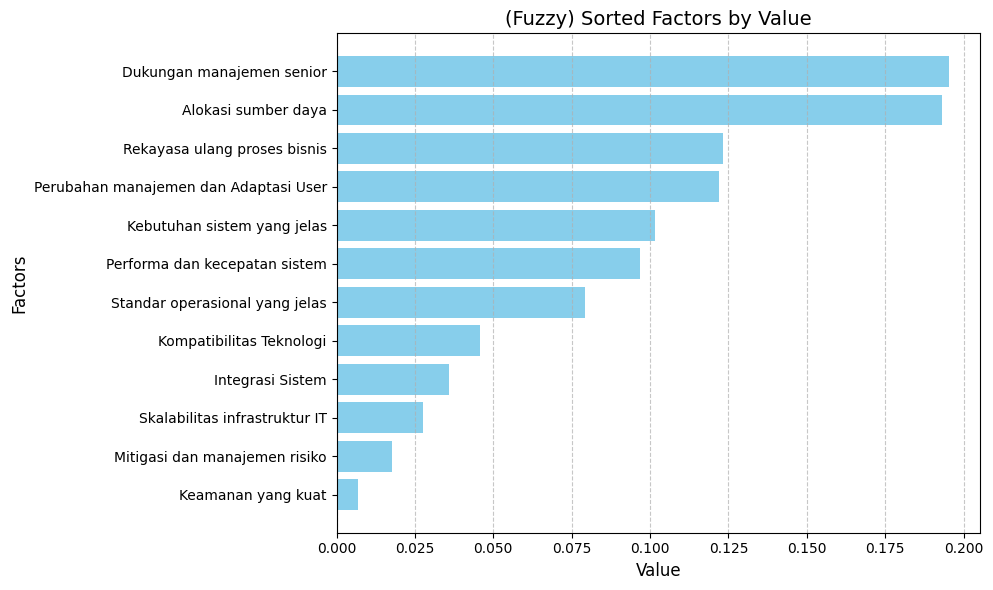

In [74]:
import matplotlib.pyplot as plt

# Data for visualization
labels = list(sorted_overall.keys())
values = list(sorted_overall.values())

# Creating the bar chart
plt.figure(figsize=(10, 6))
plt.barh(labels, values, color='skyblue')
plt.xlabel('Value', fontsize=12)
plt.ylabel('Factors', fontsize=12)
plt.title('(Fuzzy) Sorted Factors by Value', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to show highest values on top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the plot
plt.show()


In [75]:
import seaborn as sns
import matplotlib.pyplot as plt


def calculate_individual_cr(df, criteria, comparison_pairs, scale):
    n = len(criteria)
    cr_values = []

    for index, row in df.iterrows():
        fuzzy_matrix = np.zeros((n, n), dtype=object)
        for i in range(n):
            for j in range(n):
                if i == j:
                    fuzzy_matrix[i][j] = fuzzy_number(1, 1, 1)
                elif i < j:
                    response = row[comparison_pairs[(i, j)]]
                    fuzzy_value = scale.get(response, fuzzy_number(1, 1, 1))
                    fuzzy_matrix[i][j] = fuzzy_value
                    fuzzy_matrix[j][i] = fuzzy_reciprocal(fuzzy_value)

        priorities = fuzzy_ahp(fuzzy_matrix)
        _, _, cr = calculate_consistency_ratio(fuzzy_matrix, priorities)
        cr_values.append(cr)

    return cr_values

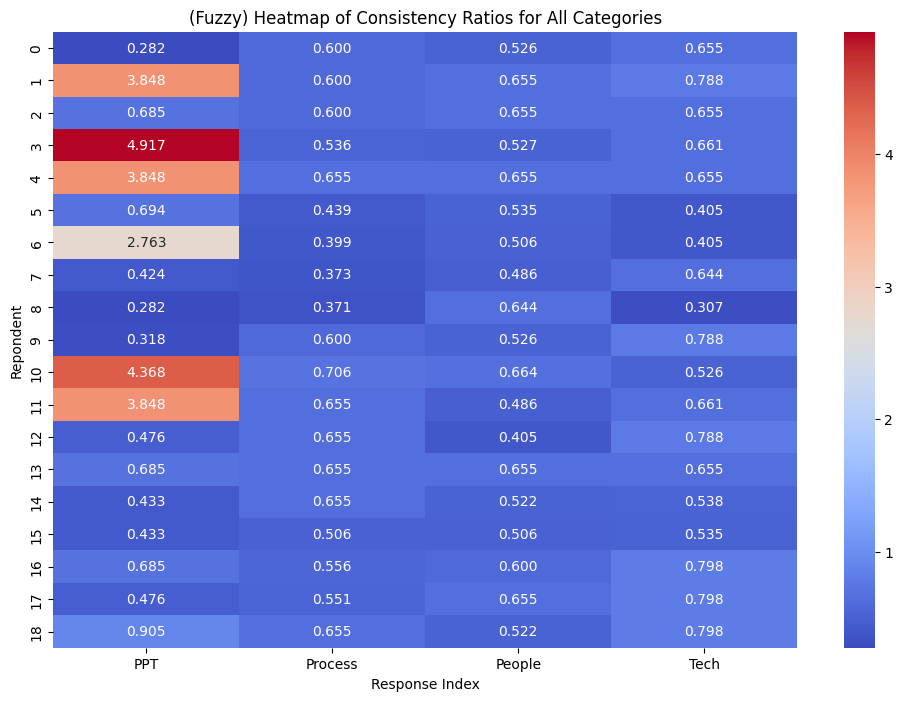

In [76]:
# Calculate CR for each response
ppt_cr_values = calculate_individual_cr(data, ppt_criteria, ppt_comparison_mapping, response_scale_ahp)
process_cr_values = calculate_individual_cr(data, process_criteria, process_comparison_mapping, response_scale_ahp)
people_cr_values = calculate_individual_cr(data, people_criteria, people_comparison_mapping, response_scale_ahp)
tech_cr_values = calculate_individual_cr(data, tech_criteria, tech_comparison_mapping, response_scale_ahp)

cr_values_combined = {
    "PPT": ppt_cr_values,
    "Process": process_cr_values,
    "People": people_cr_values,
    "Tech": tech_cr_values
}

# Create a DataFrame for visualization
cr_df_combined = pd.DataFrame(cr_values_combined)
cr_df_combined = cr_df_combined.T


# Plotting the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cr_df_combined.T, annot=True, cmap='coolwarm', fmt='.3f', cbar=True)
plt.title('(Fuzzy) Heatmap of Consistency Ratios for All Categories')
plt.xlabel('Response Index')
plt.ylabel('Repondent')
plt.show()